# Forecasting Danube Water Levels

## Introduction
Hi! 

Welcome to the water level forecasting benchmark exercise for the Danube's measuring station "Kienstock" at km 2015.21. 

There's an official [government forecast](https://www.noel.gv.at/wasserstand/#/de/Messstellen/Details/207357/WasserstandPrognose/48Stunden) which we aim to compete with using a state-of-the-art machine learning algorithm, [Long-Short-Term-Memory (LSTM)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 

enjoy ;-)

In [1]:
## Let's start with loading all dependencies

import numpy as np 
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

import sklearn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import keras 
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
from keras.models import load_model
import h5py

import os # accessing directory structure

%matplotlib inline

Using TensorFlow backend.


Let's first get the data file.

In [2]:
# check what files we have got in our working directory
# os.listdir('.')

In [3]:
!rm * # clear current working directory

In [4]:
# get the data file from github
!wget https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv

--2020-01-17 09:50:54--  https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190666 (186K) [text/plain]
Saving to: ‘danube-waterlevel-Kienstock_2002-2019.csv’

100%[======================================>] 190,666     --.-K/s   in 0.02s   

2020-01-17 09:50:55 (11.2 MB/s) - ‘danube-waterlevel-Kienstock_2002-2019.csv’ saved [190666/190666]



Then we read in the data into a Pandas DataFrame.

In [5]:
nRowsRead = None # specify 'None' if want to read whole file
df = pd.read_csv('danube-waterlevel-Kienstock_2002-2019.csv', delimiter=',', nrows = nRowsRead)
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 6574 rows and 4 columns


Let's take a quick look at what the data looks like:

In [6]:
df.head(5)

,date,min,max,mean
0,01.01.2002 00:00,369.0,417.0,393.0
1,02.01.2002 00:00,329.0,369.0,345.0
2,03.01.2002 00:00,298.0,329.0,309.0
3,04.01.2002 00:00,283.0,298.0,290.0
4,05.01.2002 00:00,263.0,283.0,273.0


We use a few definitions from a Kaggle starter kernel for our inital data exploration.

In [7]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 1000]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 2 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [19]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    # plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [14]:
# we use a subset of the data (first year) to get a first idea
df_plot = df.iloc[:365,1:4]
df_plot.dataframeName = 'danube-waterlevel-Kienstock_2002-2019.csv'

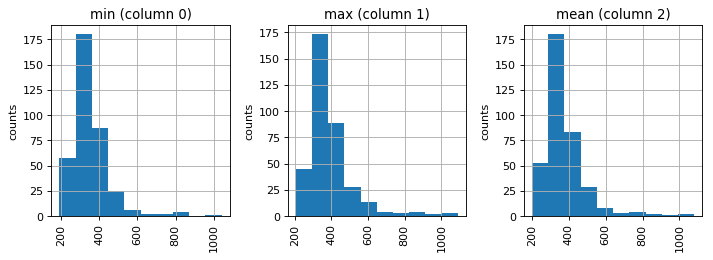

In [15]:
plotPerColumnDistribution(df_plot,3,3)

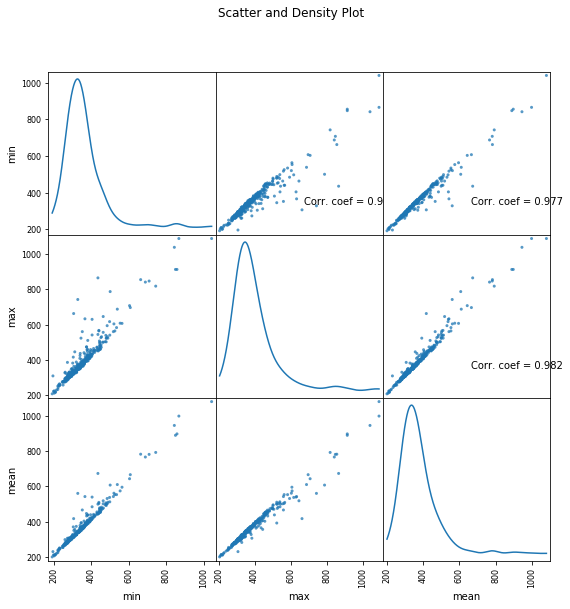

In [16]:
plotScatterMatrix(df_plot,9,10)

And finally a correlation matrix:

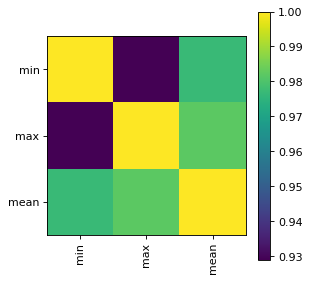

In [20]:
plotCorrelationMatrix(df_plot,4)

Let's continue with max values only. We are looking for flood maxima after all, and min and mean are highly correlated.

In [21]:
df1 = df.loc[:, ["date", "max"]]

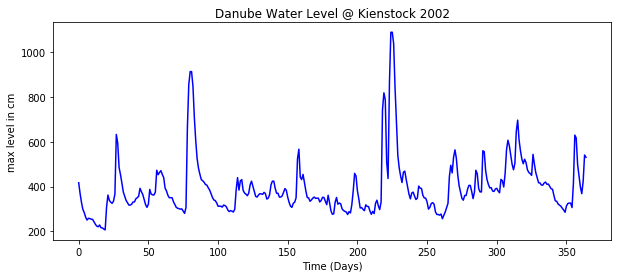

In [22]:
df1_plot = df1.iloc[:365,1:2].values.astype(float)
plt.figure(num=None, figsize=(10,4))
plt.plot(df1_plot, color = 'blue')
plt.title('Danube Water Level @ Kienstock 2002')
plt.xlabel('Time (Days)')
plt.ylabel('max level in cm')
plt.show()

You see here that there was a severe flooding in August 2002. The water was actually in the place the author is sitting in at the time of writing this code, up to about knee level. Fortunately we were renovating the house at the time, so the damage was limited.

Let's also plot all data (2002 - 2019) over time.

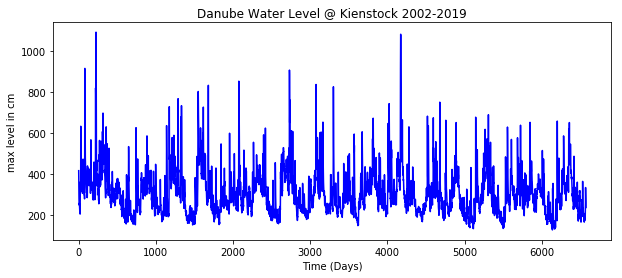

In [23]:
df1_plot = df1.iloc[:,1:2].values.astype(float)
plt.figure(num=None, figsize=(10,4))
plt.plot(df1_plot, color = 'blue')
plt.title('Danube Water Level @ Kienstock 2002-2019')
plt.xlabel('Time (Days)')
plt.ylabel('max level in cm')
plt.show()

Now we check data quality. Let's see if we have any missing data.

In [24]:
missing_data = df1.isnull()

In [25]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

date
False    6574
Name: date, dtype: int64

max
False    6573
True        1
Name: max, dtype: int64



OK, there is one missing value. We replace it with the mean of the neighbors.

In [27]:
for i in range (0, len(df1)):
    if missing_data.iloc[i,1]:
        df1.iloc[i,1] = (df1.iloc[i-1,1] + df1.iloc[i+1,1]) / 2
        print('Index: ', i, '  New value: ', df1.iloc[i,1])

Index:  5070   New value:  151.5


## Data are ready, let's feed them into our LSTM Algorithm

An application of the LSTM model for [oil price predictions](https://github.com/IBM/coursera/blob/master/coursera_ai/week3/lstm_crude_oil_price_prediction.ipynb) was presented in a Coursera lecture of the IBM Course ["Applied AI with DeepLearning"](https://www.coursera.org/learn/ai).

In [28]:
# defining our parameters as in the oil price prediction example
test_share = 0.1 # test set share of data set
timesteps = 30 # size of time window for predictions
batchsize = 64 # important for LSTM

Next we have to prepare the data sets with windows for training and test. First we define set sizes.

In [29]:
# setting data set lengths
print(f'nRow: {nRow}')# total data set size
max_train = int(nRow * (1 - test_share))
length_train = max_train - 2 * timesteps # subtract window size (twice for LSTM training)
length_train = length_train - int(length_train % batchsize) # training set size must be multiples of batchsize
nBatch_train = length_train / batchsize
upper_train = length_train + 2 * timesteps
print(f'upper_train: {upper_train}')
print(f'length_train: {length_train}')
print(f'nBatch_train: {nBatch_train}')

max_test = nRow - upper_train
length_test = max_test - timesteps # subtract window size
length_test = length_test - int(length_test % batchsize) # training set size must be multiples of batchsize
nBatch_test = length_test / batchsize
upper_test = length_test + timesteps
print(f'upper_test: {upper_test}')
print(f'length_test: {length_test}')
print(f'nBatch_test: {nBatch_test}')

nRow: 6574
upper_train: 5884
length_train: 5824
nBatch_train: 91.0
upper_test: 670
length_test: 640
nBatch_test: 10.0


Then we create data sets and check their sizes.

In [30]:
# creating data sets with feature scaling between 0 and 1.

sc = MinMaxScaler(feature_range = (0, 1))
total_set = df1.iloc[:,1:2].values
total_set_scaled = sc.fit_transform(np.float64(total_set))

training_set = total_set[0:upper_train]
print(training_set.shape)

training_set_scaled = total_set_scaled[0:upper_train]
# print(training_set_scaled.shape)

test_set = total_set[upper_train:upper_train+upper_test]
print(test_set.shape)

test_set_scaled = total_set_scaled[upper_train:upper_train+upper_test]
# print(test_set_scaled.shape)

(5884, 1)
(670, 1)


In [31]:
# Real water levels for comparison to predictions
y_train = training_set[timesteps:length_train+timesteps]
print(y_train.shape)
y_test = test_set[timesteps:length_test+timesteps]
print(y_test.shape)  

(5824, 1)
(640, 1)


In [32]:
# Creating training data structures with windows
lstm_X_train_scaled = []
lstm_Y_train_scaled = []

for i in range(timesteps, length_train+timesteps): 
    lstm_X_train_scaled.append(training_set_scaled[i-timesteps:i,0])
    lstm_Y_train_scaled.append(training_set_scaled[i:i+timesteps,0])

lstm_X_train_scaled = np.asarray(lstm_X_train_scaled)
lstm_Y_train_scaled = np.asarray(lstm_Y_train_scaled)
lstm_X_train_scaled = np.reshape(lstm_X_train_scaled, (lstm_X_train_scaled.shape[0], lstm_X_train_scaled.shape[1], 1))
lstm_Y_train_scaled = np.reshape(lstm_Y_train_scaled, (lstm_Y_train_scaled.shape[0], lstm_Y_train_scaled.shape[1], 1))

print(lstm_X_train_scaled.shape)
# print(lstm_Y_train_scaled.shape)

(5824, 30, 1)


In [33]:
# Creating test data structures
lstm_X_test_scaled = []

for i in range(timesteps, length_test+timesteps): 
    lstm_X_test_scaled.append(test_set_scaled[i-timesteps:i,0])

lstm_X_test_scaled = np.asarray(lstm_X_test_scaled)
lstm_X_test_scaled = np.reshape(lstm_X_test_scaled, (lstm_X_test_scaled.shape[0], lstm_X_test_scaled.shape[1], 1))

print(lstm_X_test_scaled.shape)
# print(lstm_X_test_scaled[0:3])    

(640, 30, 1)


Ok, everything looks fine. Next we initialize and run our LSTM model.

In [34]:
# Initialising the LSTM Model with MSE Loss-Function using Functional API

inputs1_1 = Input(batch_shape=(batchsize,timesteps,1))
lstm1_1 = LSTM(10, stateful=True, return_sequences=True)(inputs1_1)
lstm1_2 = LSTM(10, stateful=True, return_sequences=True)(lstm1_1)
output1_1 = Dense(units = 1)(lstm_2)

lstm1_reg = Model(inputs=inputs1_1, outputs = output1_1)

#adam is fast starting off and then gets slower and more precise
#mse -> mean sqare error loss function
lstm1_reg.compile(optimizer='adam', loss = 'mse')
lstm1_reg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [36]:
epochs = 30
print("Number of epochs: ", epochs)

for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    lstm1_reg.fit(lstm_X_train_scaled, lstm_Y_train_scaled, shuffle=False, epochs = 1, batch_size = batchsize)
    #resets only the states but the weights, cell and hidden are kept.
    lstm1_reg.reset_states()

Number of epochs:  30
Epoch: 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
5824/5824 [==============================] - 49s 8ms/step - loss: 0.0182
Epoch: 1
Epoch 1/1
5824/5824 [==============================] - 47s 8ms/step - loss: 0.0122
Epoch: 2
Epoch 1/1
5824/5824 [==============================] - 46s 8ms/step - loss: 0.0122
Epoch: 3
Epoch 1/1
5824/5824 [==============================] - 48s 8ms/step - loss: 0.0122
Epoch: 4
Epoch 1/1
5824/5824 [==============================] - 47s 8ms/step - loss: 0.0122
Epoch: 5
Epoch 1/1
5824/5824 [==============================] - 48s 8ms/step - loss: 0.0121
Epoch: 6
Epoch 1/1
5824/5824 [==============================] - 47s 8ms/step - loss: 0.0121
Epoch: 7
Epoch 1/1
5824/5824 [==============================] - 46s 8ms/step - loss: 0.0121
Epoch: 8
Epoch 1/1
5824/5824 [==============================] - 47s 8ms/step - loss: 0.0121
Epoch: 9
Epoch 1/1
5824/5824 [==============================] - 46s 8ms/step - loss: 0.0121
Epoch: 10


Done! We can use the learned model to get predictions on the test set and compare the to real data.

In [37]:
# save the model
# lstm1_reg.save(filepath="lstm_with_mse_30_ts.h5")

In [38]:
#load model
lstm1_reg = load_model(filepath="lstm_with_mse_30_ts.h5")

In [39]:
# get predicted data on the test set

lstm_Y_test_pred_scaled = lstm1_reg.predict(lstm_X_test_scaled, batch_size=batchsize)
lstm_reg1.reset_states()
# print(lstm_Y_test_pred_scaled.shape)

lstm_y_test_pred_scaled = lstm_Y_test_pred_scaled[:,-1,:] # keep only value of last timestep
# print(lstm_y_test_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lstm_y_test_pred = sc.inverse_transform(lstm_y_test_pred_scaled)

We use Mean Average Error (MAE) and Root Mean Squared Error (RMSE) as performance indicators.

In [40]:
# calculate mean squared error on the test set predictions
lstm_test_residuals = lstm_y_test_pred - y_test
lstm1_test_mae = np.sum(np.fabs(lstm_test_residuals)) / len(lstm_test_residuals)
lstm1_test_rmse = np.sqrt(np.sum(np.power(lstm_test_residuals,2)) / len(lstm_test_residuals))
print('LSTM test MAE: ', lstm1_test_mae)
print('LSTM test RMSE: ', lstm1_test_rmse)

LSTM test MAE:  55.20271942615509
LSTM test RMSE:  72.74869441264511


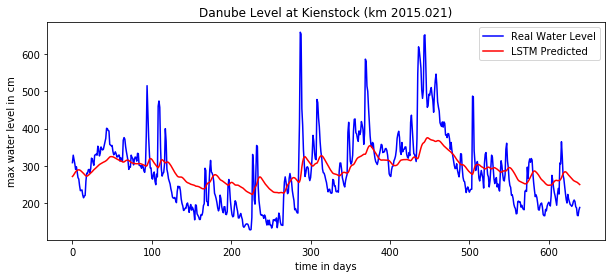

In [41]:
# Visualising the results for the whole test set
lo = 0
hi = len(y_test)
plt.figure(num=None, figsize=(10,4))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube Level at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

Ok, that's no good ;-) Quite some parameter tuning is required here.

After half a day playing with the parameters it turned out that these values perform best. 

In [42]:
# redefining our parameters
timesteps = 2
batchsize = 4

We have to recreate the data sets with the new windows for training and test

In [43]:
# setting data set lengths
print(f'nRow: {nRow}')# total data set size
max_train = int(nRow * (1 - test_share))
length_train = max_train - 2 * timesteps # subtract window size (twice for LSTM training)
length_train = length_train - int(length_train % batchsize) # training set size must be multiples of batchsize
nBatch_train = length_train / batchsize
upper_train = length_train + 2 * timesteps
print(f'upper_train: {upper_train}')
print(f'length_train: {length_train}')
print(f'nBatch_train: {nBatch_train}')

max_test = nRow - upper_train
length_test = max_test - timesteps # subtract window size
length_test = length_test - int(length_test % batchsize) # training set size must be multiples of batchsize
nBatch_test = length_test / batchsize
upper_test = length_test + timesteps
print(f'upper_test: {upper_test}')
print(f'length_test: {length_test}')
print(f'nBatch_test: {nBatch_test}')

nRow: 6574
upper_train: 5916
length_train: 5912
nBatch_train: 1478.0
upper_test: 658
length_test: 656
nBatch_test: 164.0


In [44]:
# creating data sets with feature scaling between 0 and 1.

sc = MinMaxScaler(feature_range = (0, 1))
total_set = df1.iloc[:,1:2].values
total_set_scaled = sc.fit_transform(np.float64(total_set))

training_set = total_set[0:upper_train]
print(training_set.shape)
# print(training_set_scaled[0:3])

training_set_scaled = total_set_scaled[0:upper_train]
# print(training_set_scaled.shape)
# print(training_set_scaled[0:3])

test_set = total_set[upper_train:upper_train+upper_test]
print(test_set.shape)
# print(test_set[0:3])

test_set_scaled = total_set_scaled[upper_train:upper_train+upper_test]
# print(test_set_scaled.shape)
# print(test_set_scaled[0:3])

(5916, 1)
(658, 1)


In [45]:
# Real water levels for comparison to predictions

y_train = training_set[timesteps:length_train+timesteps]
print(y_train.shape)
# print(y_train[:3])
y_test = test_set[timesteps:length_test+timesteps]
print(y_test.shape)  
# print(y_test[:3])

(5912, 1)
(656, 1)


In [46]:
# Creating training data structures with windows
lstm_X_train_scaled = []
lstm_Y_train_scaled = []

for i in range(timesteps, length_train+timesteps): 
    lstm_X_train_scaled.append(training_set_scaled[i-timesteps:i,0])
    lstm_Y_train_scaled.append(training_set_scaled[i:i+timesteps,0])

lstm_X_train_scaled = np.asarray(lstm_X_train_scaled)
lstm_Y_train_scaled = np.asarray(lstm_Y_train_scaled)
lstm_X_train_scaled = np.reshape(lstm_X_train_scaled, (lstm_X_train_scaled.shape[0], lstm_X_train_scaled.shape[1], 1))
lstm_Y_train_scaled = np.reshape(lstm_Y_train_scaled, (lstm_Y_train_scaled.shape[0], lstm_Y_train_scaled.shape[1], 1))

print(lstm_X_train_scaled.shape)
# print(lstm_X_train_scaled[:2])
# print(lstm_Y_train_scaled.shape)
# print(lstm_Y_train_scaled[:2])

(5912, 2, 1)


In [47]:
# Creating test data structures
lstm_X_test_scaled = []

for i in range(timesteps, length_test+timesteps): 
    lstm_X_test_scaled.append(test_set_scaled[i-timesteps:i,0])

lstm_X_test_scaled = np.asarray(lstm_X_test_scaled)
lstm_X_test_scaled = np.reshape(lstm_X_test_scaled, (lstm_X_test_scaled.shape[0], lstm_X_test_scaled.shape[1], 1))

print(lstm_X_test_scaled.shape)
# print(lstm_X_test_scaled[0:3])    

(656, 2, 1)


Again we initialize and run an LSTM model, now a mich simpler one.

In [48]:
# Initialising a simplified LSTM Model with MSE Loss-Function using Functional API

inputs_1 = Input(batch_shape=(batchsize,timesteps,1))
lstm_1 = LSTM(3, stateful=True, return_sequences=True)(inputs_1)
output_1 = Dense(units = 1)(lstm_1)

lstm_reg = Model(inputs=inputs_1, outputs = output_1)

#adam is fast starting off and then gets slower and more precise
#mse -> mean sqare error loss function
lstm_reg.compile(optimizer='adam', loss = 'mse')
lstm_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (4, 2, 1)                 0         
_________________________________________________________________
lstm_3 (LSTM)                (4, 2, 3)                 60        
_________________________________________________________________
dense_2 (Dense)              (4, 2, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [49]:
epochs = 30
print("Number of epochs: ", epochs)

#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    lstm_reg.fit(lstm_X_train_scaled, lstm_Y_train_scaled, shuffle=False, epochs = 1, batch_size = batchsize)
    #resets only the states but the weights, cell and hidden are kept.
    lstm_reg.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Number of epochs:  30
Epoch: 0
Epoch 1/1
5912/5912 [==============================] - 32s 5ms/step - loss: 0.0083
Epoch: 1
Epoch 1/1
5912/5912 [==============================] - 31s 5ms/step - loss: 0.0066
Epoch: 2
Epoch 1/1
5912/5912 [==============================] - 29s 5ms/step - loss: 0.0057
Epoch: 3
Epoch 1/1
5912/5912 [==============================] - 30s 5ms/step - loss: 0.0057
Epoch: 4
Epoch 1/1
5912/5912 [==============================] - 31s 5ms/step - loss: 0.0056
Epoch: 5
Epoch 1/1
5912/5912 [==============================] - 30s 5ms/step - loss: 0.0055
Epoch: 6
Epoch 1/1
5912/5912 [==============================] - 32s 5ms/step - loss: 0.0055
Epoch: 7
Epoch 1/1
5912/5912 [==============================] - 32s 5ms/step - loss: 0.0053
Epoch: 8
Epoch 1/1
5912/5912 [==============================] - 30s 5ms/step - loss: 0.0050
Epoch: 9
Epoch 1/1
5912/5912 [==============================] - 35s 6ms/step - loss: 0.0048
Epoch: 10
Epoch 1/1
5912/5912 [===========================

Done! Again we get predictions and compare to the real data. 

In [50]:
# save the model
lstm_reg.save(filepath="lstm_with_mse_2_ts.h5")

In [51]:
#load model
lstm_reg = load_model(filepath="lstm_with_mse_2_ts.h5")

In [52]:
# get predicted data on the test set

lstm_Y_test_pred_scaled = lstm_reg.predict(lstm_X_test_scaled, batch_size=batchsize)
lstm_reg.reset_states()
print(lstm_Y_test_pred_scaled.shape)

lstm_y_test_pred_scaled = lstm_Y_test_pred_scaled[:,-1,:] # keep only value of last timestep
print(lstm_y_test_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lstm_y_test_pred = sc.inverse_transform(lstm_y_test_pred_scaled)

(656, 2, 1)
(656, 1)


In [53]:
# calculate mean squared error on the test set predictions
lstm_test_residuals = lstm_y_test_pred - y_test
lstm_test_mae = np.sum(np.fabs(lstm_test_residuals)) / len(lstm_test_residuals)
lstm_test_rmse = np.sqrt(np.sum(np.power(lstm_test_residuals,2)) / len(lstm_test_residuals))
print('LSTM2 test MAE: ', lstm_test_mae)
print('LSTM2 test RMSE: ', lstm_test_rmse)
print('LSTM1 test MAE: ', lstm1_test_mae)
print('LSTM1 test RMSE: ', lstm1_test_rmse)

LSTM2 test MAE:  28.441575934247272
LSTM2 test RMSE:  39.672112517052284
LSTM1 test MAE:  55.20271942615509
LSTM1 test RMSE:  72.74869441264511


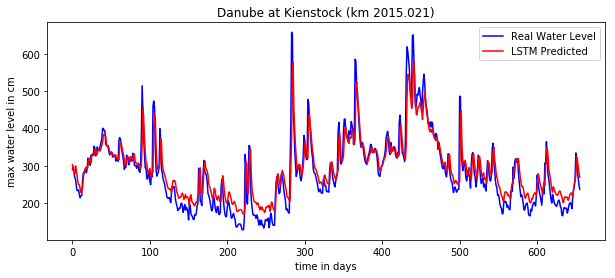

In [54]:
# Visualising the results
lo = 0
hi = len(y_test)
plt.figure(num=None, figsize=(10,4))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

That looks much better now. Let's zoom in:

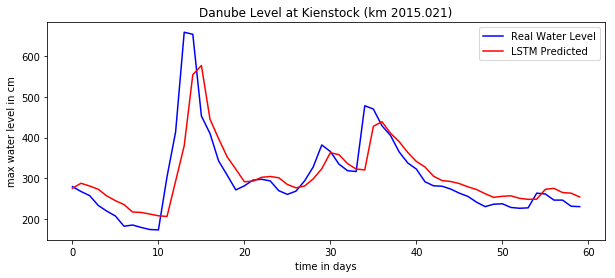

In [55]:
# Visualising the results for a couple of months
lo = 270
hi = min(330, len(y_test))
plt.figure(num=None, figsize=(10,4))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube Level at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

That looks quite ok. So we are happy and deploy a live forecast based on a data stream?

Wait a minute. We need to benchmark this with some other model.

Let's try standard Linear Regression as a baseline, with the same data.

In [56]:
# Creating training data structures with windows for LinReg
# It is actually the same as the LSTM data structure, just shaped differently (one array dimension less)

lr_timesteps = timesteps # window size for LinReg, must not be larger that LSTM window size
lr_X_train_scaled = []

for i in range(timesteps, length_train+timesteps): 
    lr_X_train_scaled.append(training_set_scaled[i-lr_timesteps:i,0])

lr_X_train_scaled = np.asarray(lr_X_train_scaled)
lr_y_train_scaled = training_set_scaled[timesteps:length_train+timesteps]

print(lr_X_train_scaled.shape)
# print(lr_y_train_scaled.shape)

(5912, 2)


In [57]:
# Creating test data structure for LinReg
lr_X_test_scaled = []

for i in range(timesteps, length_test+timesteps): 
    lr_X_test_scaled.append(test_set_scaled[i-lr_timesteps:i,0])

lr_X_test_scaled = np.asarray(lr_X_test_scaled)

print(lr_X_test_scaled.shape)

(656, 2)


We prepared the data for Linear Regression, now we do the fit.

In [58]:
# do the LinReg fit
lr_model = LinearRegression()
lr_model.fit(lr_X_train_scaled, lr_y_train_scaled)
# the regression coefficients
print ('Coefficients: ', lr_model.coef_)

Coefficients:  [[-0.30002795  1.20821005]]


Ok, that's mostly the previous day's value with some correction from the day before

In [59]:
# get predicted data on the test set
lr_y_test_pred_scaled = lr_model.predict(lr_X_test_scaled)
# print(lr_y_test_pred_scaled.shape)

# inverse transform (reverse feature scaling)
lr_y_test_pred = sc.inverse_transform(lr_y_test_pred_scaled)

# print(lr_y_test_pred.shape)

In [60]:
# calculate mean squared error on the test set predictions
lr_test_residuals = lr_y_test_pred - y_test
lr_test_mae = np.sum(np.fabs(lr_test_residuals)) / len(lr_test_residuals)
lr_test_rmse = np.sqrt(np.sum(np.power(lr_test_residuals,2)) / len(lr_test_residuals))
print('LinReg test MAE: ', lr_test_mae)
print('LinReg test RMSE: ', lr_test_rmse)
print('LSTM test MAE: ', lstm_test_mae)
print('LSTM test RMSE: ', lstm_test_rmse)

LinReg test MAE:  19.965632505113344
LinReg test RMSE:  32.86084014760473
LSTM test MAE:  28.441575934247272
LSTM test RMSE:  39.672112517052284


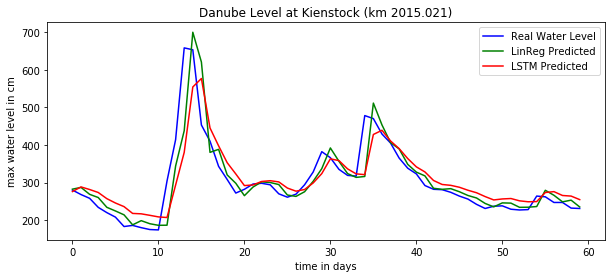

In [61]:
# Visualising the results for a couple of months
lo = 270
hi = min(330, len(y_test))
plt.figure(num=None, figsize=(10,4))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lr_y_test_pred[lo:hi], color = 'green', label = 'LinReg Predicted')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube Level at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

OK, very interesting, the simple benchmark LinReg model actually performs quite a bit better!

A trivial prediction is just to take the previous day's value, let's try that as well:

In [62]:
triv_y_test_pred = test_set[timesteps-1:length_test+timesteps-1]
print(triv_y_test_pred.shape)

(656, 1)


In [63]:
# calculate mean squared error on the trivial predictions
triv_residuals = triv_y_test_pred - y_test
triv_mae = np.sum(np.fabs(triv_residuals)) / len(triv_residuals)
triv_rmse = np.sqrt(np.sum(np.power(triv_residuals,2)) / len(triv_residuals))
print('Trivial test MAE: ', triv_mae)
print('Trivial test RMSE:', triv_rmse)
print('LinReg test MAE: ', lr_test_mae)
print('LinReg test RMSE: ', lr_test_rmse)
print('LSTM test MAE: ', lstm_test_mae)
print('LSTM test RMSE: ', lstm_test_rmse)

Trivial test MAE:  19.771341463414632
Trivial test RMSE: 34.89011496041851
LinReg test MAE:  19.965632505113344
LinReg test RMSE:  32.86084014760473
LSTM test MAE:  28.441575934247272
LSTM test RMSE:  39.672112517052284


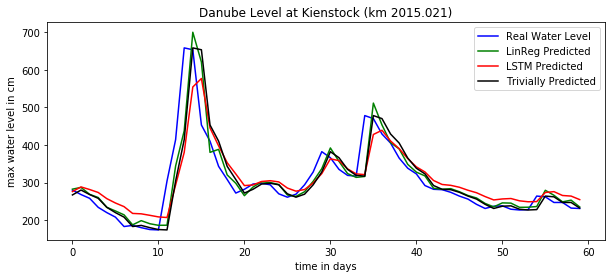

In [64]:
# Visualising the results for a couple of months
lo = 270
hi = min(330, len(y_test))
plt.figure(num=None, figsize=(10,4))
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lr_y_test_pred[lo:hi], color = 'green', label = 'LinReg Predicted')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.plot(triv_y_test_pred[lo:hi], color = 'black', label = 'Trivially Predicted')
plt.title('Danube Level at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

Surprise, surprise: the trivial prediction is doing rather well!

Let's look at the whole test data set:

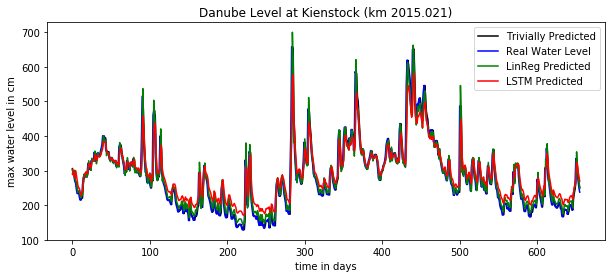

In [65]:
# Visualising the results for a couple of months
lo = 0
hi = len(y_test)
plt.figure(num=None, figsize=(10,4))
plt.plot(triv_y_test_pred[lo:hi], color = 'black', label = 'Trivially Predicted')
plt.plot(y_test[lo:hi], color = 'blue', label = 'Real Water Level')
plt.plot(lr_y_test_pred[lo:hi], color = 'green', label = 'LinReg Predicted')
plt.plot(lstm_y_test_pred[lo:hi], color = 'red', label = 'LSTM Predicted')
plt.title('Danube Level at Kienstock (km 2015.021)')
plt.xlabel('time in days')
plt.ylabel('max water level in cm')
plt.legend()
plt.show()

Ok, we can't even see the trivial prediction on this scale because it is so close to the real data that the line is hidden.

Let's also have look at the residual's histograms: 

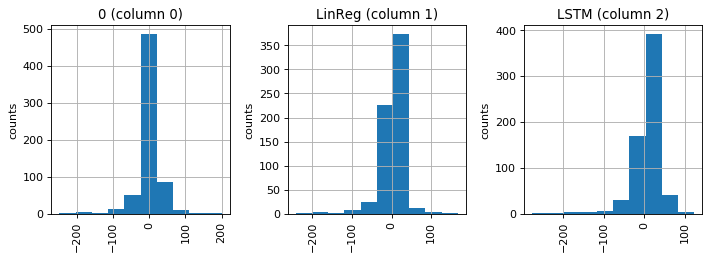

In [66]:
res = pd.DataFrame(triv_residuals[:,0])
res.insert(loc=1,column='LinReg',value=lr_test_residuals[:,0])
res.insert(loc=2,column='LSTM',value=lstm_test_residuals[:,0])
res.rename(columns={0: 'Trivial'})
plotPerColumnDistribution(res,3,3)

So, what did we learn? 

River water level data seem to be inherently chaotic and hence unsuited for this approach.

That does't mean that we have to give up. A recomented next step ist to feed a regressor with data of different reating stations along the river, offset by the respective delays of the water flowing down. That's for the next project, however ;-)

Thanx a lot for following through until here! If you'd like to comment, please drop me a mail at [msg@donaugarten.at](mailto:msg@donaugarten.at).

Marko